In [2]:
#getting DB user and PWD info
import os

dbUser = os.environ.get('globalSecretUser')
dbPwd = os.environ.get('globalSecretKey')

In [3]:

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession 
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
conf = SparkConf().setAppName("DataVisualization").setMaster("local")
sc = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()



# Read Credit Card Info from DB to a Data Frame
df_loan=sc.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user=dbUser,\
                                     password=dbPwd,\
                                     url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                                     dbtable="creditcard_capstone.CDW_SAPP_loan_application").load()

df_loan.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP002448|                No|            No|         0|    Graduate|  Male|   Low|    Yes|        Rural|           No|
|      LP001953|               Yes|           Yes|         1|    Graduate|  Male|Medium|    Yes|    Semiurban|           No|
|      LP001520|               Yes|           Yes|         0|    Graduate|  Male|Medium|    Yes|    Semiurban|           No|
|      LP001744|               Yes|           Yes|         0|    Graduate|  Male|   Low|     No|    Semiurban|           No|
|      LP002224|                No|           Yes|         0|    Graduate|  Male|   Low|     No|        Urban|           No|


5.1 Create a bar chart that shows the difference in application approvals for Married Men vs Married Women based on income ranges. (number of approvals)

1. Filter by application status = Y and married status = Yes
2. Group by Income and Gender to get the aggregated count of transaction

In [4]:
df_loan.filter((df_loan.Married == 'Yes') & (df_loan.Application_Status == 'Yes'))\
        .groupBy('Income', 'Gender') \
        .agg(count('Application_ID').alias('Transaction Count')) \
        .orderBy('Transaction Count', ascending=False).show()


+------+------+-----------------+
|Income|Gender|Transaction Count|
+------+------+-----------------+
|   Low|  Male|              119|
|Medium|  Male|               83|
|  High|  Male|               17|
|   Low|Female|               10|
|Medium|Female|                4|
|  High|Female|                3|
+------+------+-----------------+



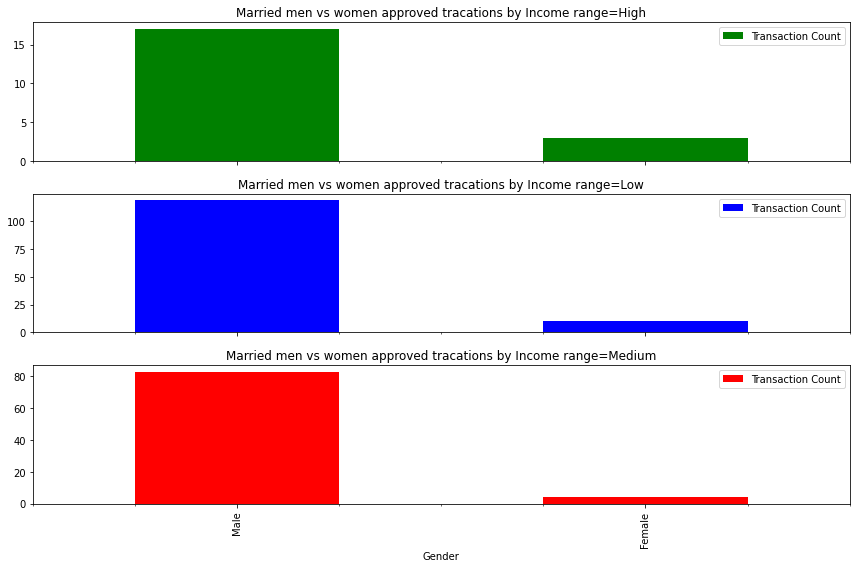

In [8]:
df_loan_pd = df_loan.filter((df_loan.Married == 'Yes') & (df_loan.Application_Status == 'Yes'))\
        .groupBy('Income', 'Gender') \
        .agg(count('Application_ID').alias('Transaction Count')) \
        .orderBy('Transaction Count', ascending=False).toPandas()


df_group = df_loan_pd.groupby('Income')
fig, axes = plt.subplots(df_group.ngroups, sharex=True, figsize=(12, 8))
colorrange = ['g', 'b','r']
for i, (Income, d) in enumerate(df_group):
    ax = d.plot.bar(x='Gender', y='Transaction Count', ax=axes[i], color=colorrange[i])
    ax.legend()
    ax.set_title('Married men vs women approved tracations by Income range=%s'%Income)
fig.tight_layout()

5.2 Create and plot a chart that shows the difference in application approvals based on Property Area. 
1. Group by property Area and Application status
2. Aggregate by Application ID to get the transaction count

In [13]:
df_loan \
        .groupBy('Property_Area', 'Application_Status') \
        .agg(count('Application_ID').alias('Transaction Count')) \
        .sort('Property_Area', 'Application_Status').show()

+-------------+------------------+-----------------+
|Property_Area|Application_Status|Transaction Count|
+-------------+------------------+-----------------+
|        Rural|                No|               59|
|        Rural|               Yes|               90|
|    Semiurban|                No|               44|
|    Semiurban|               Yes|              153|
|        Urban|                No|               61|
|        Urban|               Yes|              104|
+-------------+------------------+-----------------+



Dynamically creating 3 different bar charts by property area to plot application status with transaction count.

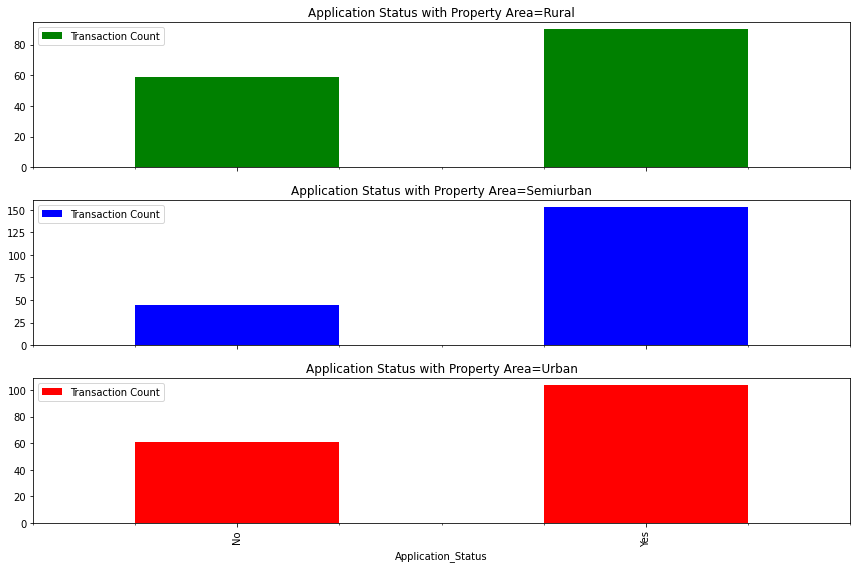

In [14]:
df_loan_pd= df_loan \
        .groupBy('Property_Area', 'Application_Status') \
        .agg(count('Application_ID').alias('Transaction Count')) \
        .sort('Property_Area', 'Application_Status').toPandas()

df_group = df_loan_pd.groupby('Property_Area')
fig, axes = plt.subplots(df_group.ngroups, sharex=True, figsize=(12, 8))
colorrange = ['g', 'b','r']
for i, (Property_Area, d) in enumerate(df_group):
    ax = d.plot.bar(x='Application_Status', y='Transaction Count', ax=axes[i], title=Property_Area, color=colorrange[i])
    ax.legend()
    ax.set_title('Application Status with Property Area=%s'%Property_Area)
fig.tight_layout()

Create a multi-bar plot that shows the total number of approved applications per each application demographic. 
Group by all dimensional attributes with application status = y 

In [15]:
df_loan.filter((df_loan.Application_Status=='Yes'))\
        .groupBy('Income', 'Married', 'Gender','Credit_History', 'Dependents','Education', 'Property_Area','Self_Employed') \
        .agg(count('Application_ID').alias('Transaction Count')) \
        .orderBy('Transaction Count', ascending=False).show(50)

+------+-------+------+--------------+----------+------------+-------------+-------------+-----------------+
|Income|Married|Gender|Credit_History|Dependents|   Education|Property_Area|Self_Employed|Transaction Count|
+------+-------+------+--------------+----------+------------+-------------+-------------+-----------------+
|   Low|    Yes|  Male|           Yes|         0|    Graduate|    Semiurban|           No|               22|
|   Low|    Yes|  Male|           Yes|         0|    Graduate|        Rural|           No|               14|
|Medium|    Yes|  Male|           Yes|         2|    Graduate|    Semiurban|           No|               12|
|   Low|    Yes|  Male|           Yes|         0|    Graduate|        Urban|           No|               11|
|   Low|     No|  Male|           Yes|         0|    Graduate|    Semiurban|           No|               11|
|Medium|    Yes|  Male|           Yes|         0|    Graduate|    Semiurban|           No|                9|
|   Low|    Yes|  M

<AxesSubplot:title={'center':'Approved Application by Married Status'}, ylabel='Married'>

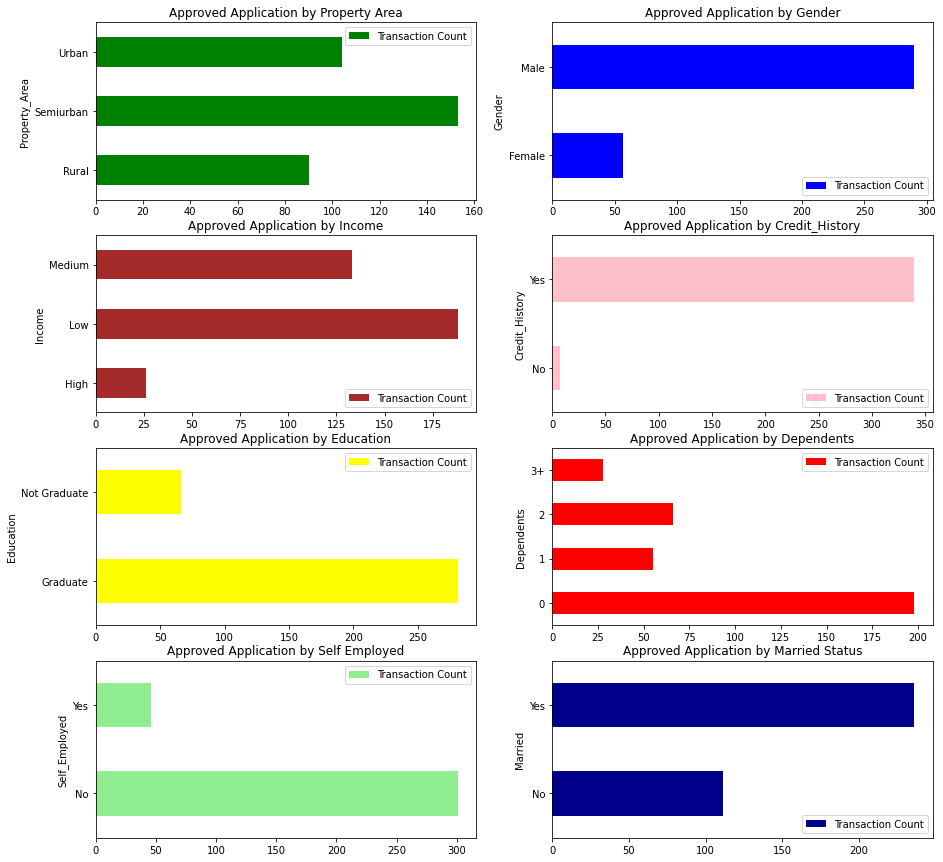

In [16]:
df_loan_pd = df_loan.filter((df_loan.Application_Status=='Yes')) \
        .groupBy('Income', 'Married','Gender','Credit_History', 'Dependents','Education', 'Property_Area','Self_Employed') \
        .agg(count('Application_ID').alias('Transaction Count')) \
        .orderBy('Transaction Count', ascending=False).toPandas()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

df_loan_pd.groupby('Property_Area').agg({'Transaction Count':'sum'}).plot(kind='barh', color='g', ax=axes[0][0], title='Approved Application by Property Area')
df_loan_pd.groupby('Gender').agg({'Transaction Count':'sum'}).plot(kind='barh', color='b', ax=axes[0][1], title='Approved Application by Gender')

df_loan_pd.groupby('Income').agg({'Transaction Count':'sum'}).plot(kind='barh',color='brown', ax=axes[1][0], title='Approved Application by Income')
df_loan_pd.groupby('Credit_History').agg({'Transaction Count':'sum'}).plot(kind='barh', color='pink', ax=axes[1][1], title='Approved Application by Credit_History')

df_loan_pd.groupby('Education').agg({'Transaction Count':'sum'}).plot(kind='barh', color='yellow', ax=axes[2][0], title='Approved Application by Education')
df_loan_pd.groupby('Dependents').agg({'Transaction Count':'sum'}).plot(kind='barh', color='r', ax=axes[2][1], title='Approved Application by Dependents')

df_loan_pd.groupby('Self_Employed').agg({'Transaction Count':'sum'}).plot(kind='barh', color='lightgreen', ax=axes[3][0], title='Approved Application by Self Employed')
df_loan_pd.groupby('Married').agg({'Transaction Count':'sum'}).plot(kind='barh', color='darkblue', ax=axes[3][1], title='Approved Application by Married Status')